In [138]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [234]:
pairs = ['btc_usd', 'eth_usd', 'ltc_usd', 'xrp_usd']

def pair_currencies(pairs):
    currencies = ['usd']
    for pair in pairs:
        currencies.append(pair.partition('_')[0])
    return currencies

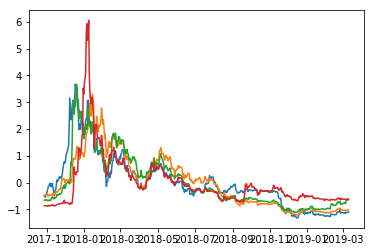

In [271]:
def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    return pd.DataFrame(prices, index = dates)

data = prep_data('data.p')
data_minute = prep_data('data-minute.p')
data_norm = (data - data.mean()) / data.std()
plt.plot(data_norm)

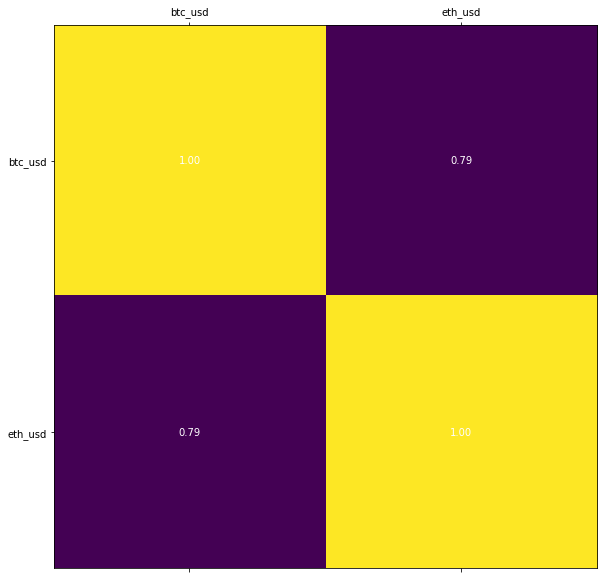

In [229]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(prices)

In [294]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day'''
    currencies = pair_currencies(data.columns)
    balances = dict.fromkeys(currencies, 0)
    results = []
    for (date, prices) in data.iterrows():
        orders = strategy.step(balances, prices)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        balance_values = { c: qty * price(c) for c, qty in balances.items()}
        results.append({ 'date': date, 'balances': balances.copy(), 'balance_values': balance_values, 'pnl': current_pnl, })
    return results

def plot_results(results):
    print('Final pnl:')
    print(results[-1]['pnl'])
    print('Final balances:')
    print(results[-1]['balances'])
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    balance_values = pd.DataFrame([x['balance_values'] for x in results], index = [x['date'] for x in results])
    pnls = pd.DataFrame([x['pnl'] for x in results], index = [x['date'] for x in results])
    pnls.plot(ax=axs[0])
    balance_values.plot(ax=axs[1])
    plt.show()

Final pnl:
0.0
Final balances:
{'usd': 0.0, 'btc': 0, 'eth': 0, 'ltc': 0, 'xrp': 0}


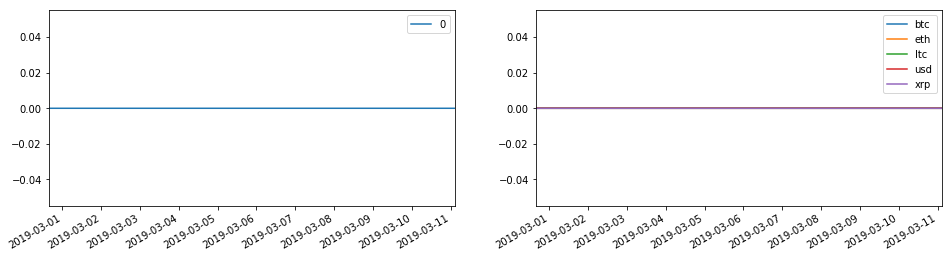

In [295]:
from strategy import Strategy, HoldStrategy

plot_results(evaluate(HoldStrategy(), data_minute))

Final pnl:
69921.47360612657
Final balances:
{'usd': 63967.10825418305, 'btc': 0.14001040802898476, 'eth': 0.0, 'ltc': 92.9270270556147, 'xrp': 0.0}


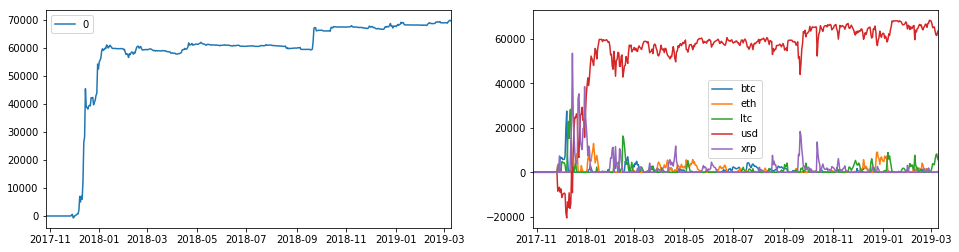

In [ ]:
from collections import deque

class S(Strategy):
    def __init__(self, correlation_window_size = 32, movement_half_life = 4, min_edge = 0.03, max_edge = 1, size = 1000):
        '''size is usd per pct edge'''
        self.window = deque() # could be a ring buffer if we cared about performance
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.a = 0.5**(1/movement_half_life)
        self.moving_prices = None
        
    def desired_balance_value(self, delta):
        '''Returns the desired value in USD of the balance for the currency at some delta from fair'''
        if abs(delta) < self.min_edge:
            return 0
        if abs(delta) >= self.max_edge:
            return 0
        return delta * 100 * self.size
        
    def step(self, balances, prices):
        if self.moving_prices is None:
            self.moving_prices = prices
        self.moving_prices = self.a * self.moving_prices + (1 - self.a) * prices
        
        self.window.append(prices)
        while len(self.window) > self.correlation_window_size:
            self.window.popleft()
        if len(self.window) < self.correlation_window_size:
            return {}
        
        windowframe = pd.DataFrame(self.window)
        
        # Calaculates fair movements by averaging correlated movements between all pairs, weighted by r^2
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment
        #    + eth_movement * r_eth^3 * stddev_btc/stddev_eth
        #    + ltc_movement * r_ltc^3 * stddev_btc/stddev_ltc
        #    + xrp_movement * r_xrp^3 * stddev_btc/stddev_xrp)
        #   / (1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        
        stddevs = windowframe.std() # filter if stddev too high?
        corr = windowframe.corr()
        movements = prices - self.moving_prices
        predicted_movements = (movements * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        confidences = corr ** 2
        fair_movements = (predicted_movements * confidences).sum(axis=1) / confidences.sum(axis=1)
#         fairs = fair_movements + self.moving_prices
        
#         print(corr, pct_movements)
#         print(predicted_movements)
#         print(confidences)
#         print(movements, fair_movements)
#         print('')
#         print('pct_movements')
#         print(pct_movements)
#         print('fair_pct_movements')
#         print(fair_pct_movements)
        orders = {}
        for pair in movements.index:
            currency = pair.partition('_')[0]
            delta = (movements[pair] - fair_movements[pair]) / self.moving_prices[pair]
            orders[pair] = self.desired_balance_value(delta) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(S(correlation_window_size = 32, movement_half_life = 4, min_edge = 0), data))
plot_results(evaluate(S(correlation_window_size = 1440, movement_half_life = 32, min_edge = 0), data_minute))